In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Studio algoritmi per trovare i prezzi di riferimento per il calcolo delle variazioni di prezzo

In [2]:
# Funzione per generare prezzi casuali basati su una distribuzione delle variazioni
def genera_prezzi(num_giorni, distribuzione_variazioni):
    np.random.seed(0)  # Per riproducibilità
    prezzi = [100]  # Prezzo iniziale
    variazioni = np.random.choice(list(distribuzione_variazioni.keys()), 
                                  size=num_giorni-1, 
                                  p=list(distribuzione_variazioni.values()))
    
    for variazione in variazioni:
        prezzi.append(prezzi[-1] * (1 + variazione))
    
    return pd.DataFrame({'Timestamp': pd.date_range(start='2023-01-01', periods=num_giorni, freq='D'), 
                         'Price': prezzi})

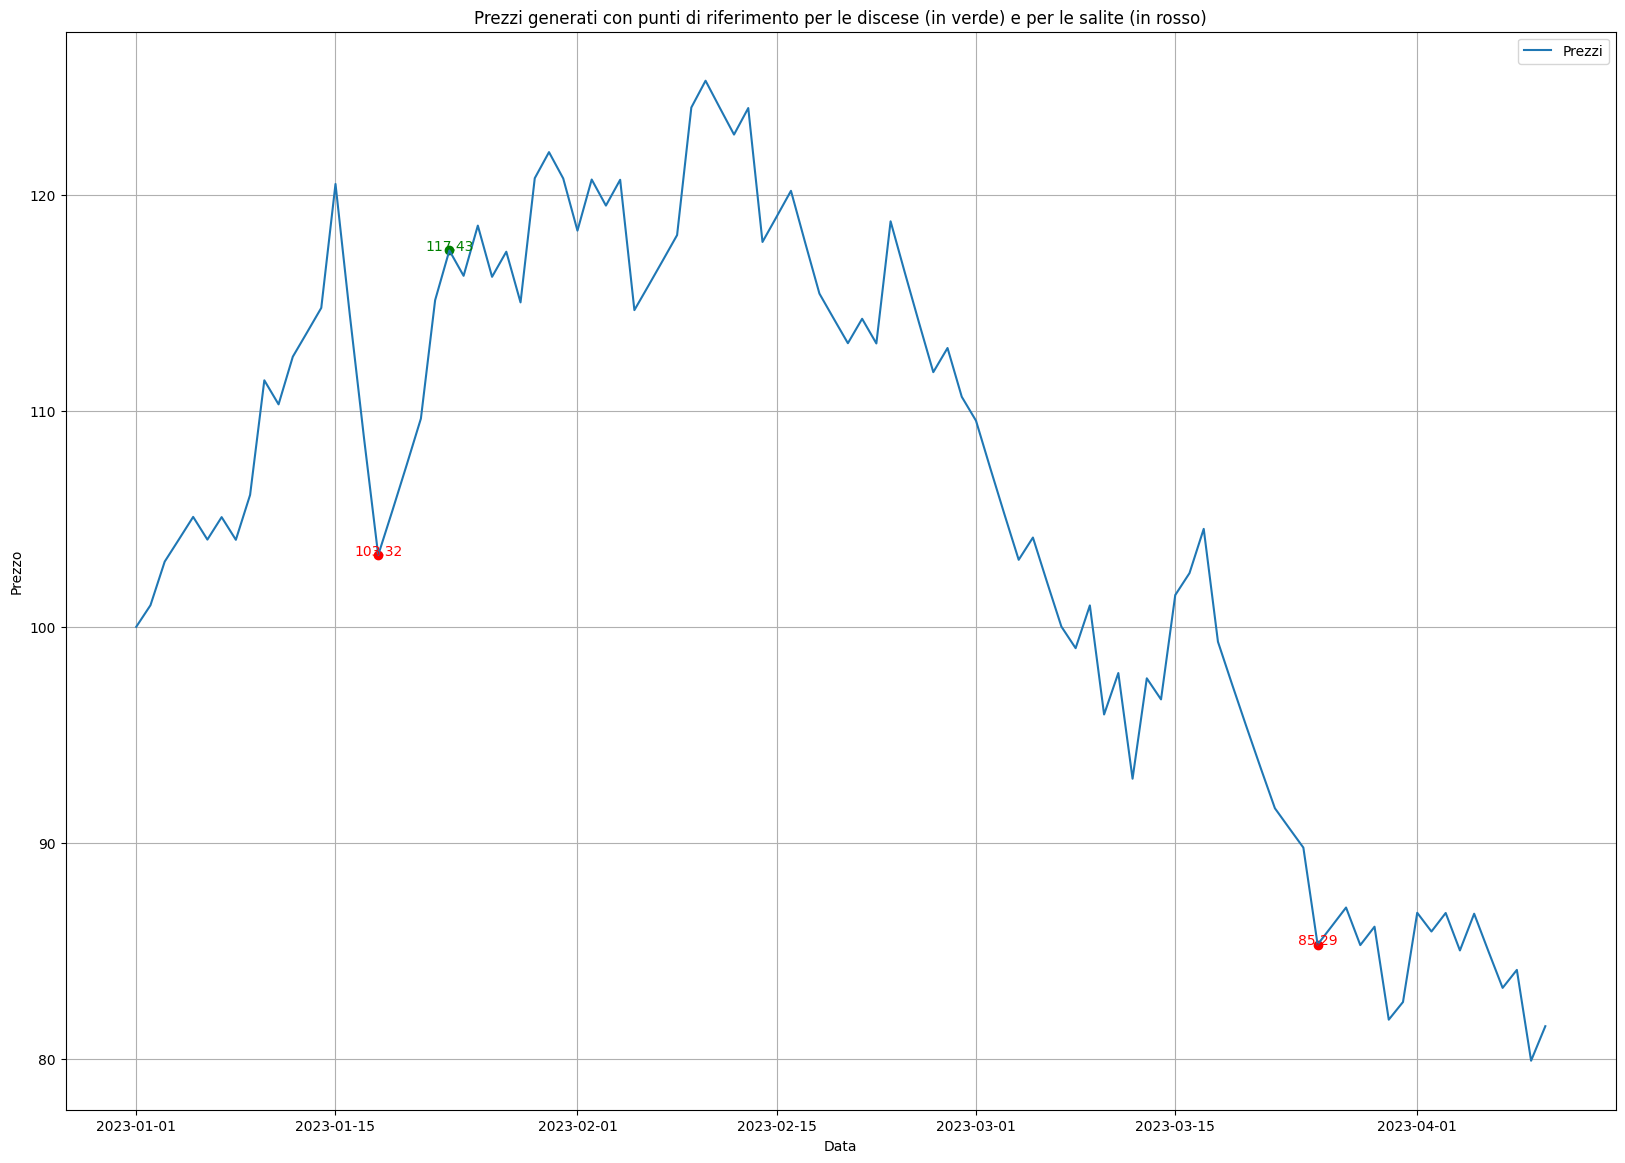

In [3]:
# Distribuzione delle variazioni (esempio)
distribuzione_variazioni = {
    -0.05: 0.1,
    -0.02: 0.2,
    -0.01: 0.2,
    0.01: 0.2,
    0.02: 0.2,
    0.05: 0.1
}

# Genera prezzi
num_giorni = 100
dati = genera_prezzi(num_giorni, distribuzione_variazioni)

# Calcola variazioni
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Parametri
soglia_calcolo_variazioni_discesa = 0.1
soglia_calcolo_variazioni_salita = 0.1

prezzi_riferimento_discesa = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente < 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_discesa.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True

prezzi_riferimento_salita = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente > 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_salita.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True


# Crea il grafico
plt.figure(figsize=(20, 14))
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
for timestamp, prezzo_riferimento in prezzi_riferimento_discesa:
    plt.scatter(timestamp, prezzo_riferimento, color='green')
    plt.text(timestamp, prezzo_riferimento, str(round(prezzo_riferimento,2)), color='green', fontsize=10, ha='center')
for timestamp, prezzo_riferimento in prezzi_riferimento_salita:
    plt.scatter(timestamp, prezzo_riferimento, color='red')
    plt.text(timestamp, prezzo_riferimento, str(round(prezzo_riferimento,2)), color='red', fontsize=10, ha='center')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Prezzi generati con punti di riferimento per le discese (in verde) e per le salite (in rosso)')
plt.legend()
plt.grid()
plt.show()

### Algoritmo